Saving jigsaw-toxic-comment-classification-challenge.zip to jigsaw-toxic-comment-classification-challenge (5).zip
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: jigsaw/sample_submission.csv.zip  
  inflating: jigsaw/test.csv.zip     
  inflating: jigsaw/test_labels.csv.zip  
  inflating: jigsaw/train.csv.zip    
Archive:  jigsaw/train.csv.zip
  inflating: jigsaw/train.csv        
Dataset shape: (159571, 8)
Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
Balanced dataset: (15000, 2)  Toxic ratio

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:57:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Baseline (300 trees) ===
{'AUC': np.float64(0.9319471111111111), 'Precision': 0.9272097053726169, 'Recall': 0.7133333333333334, 'F1': 0.8063300678221552}
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1500
           1       0.93      0.71      0.81       750

    accuracy                           0.89      2250
   macro avg       0.90      0.84      0.86      2250
weighted avg       0.89      0.89      0.88      2250



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:57:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Fine-tuned (600 trees) ===
{'AUC': np.float64(0.9368737777777778), 'Precision': 0.9063492063492063, 'Recall': 0.7613333333333333, 'F1': 0.827536231884058}
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1500
           1       0.91      0.76      0.83       750

    accuracy                           0.89      2250
   macro avg       0.90      0.86      0.88      2250
weighted avg       0.90      0.89      0.89      2250



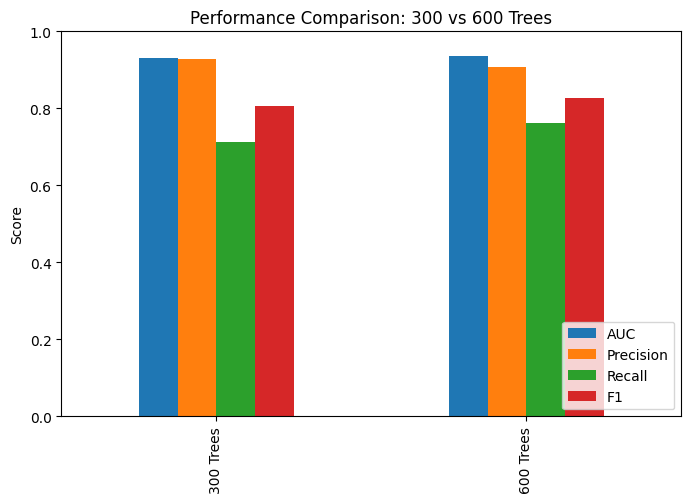

✅ Final fine-tuned XGBoost model saved to toxicity_xgb.pkl
{'player': '12345', 'game': 'abcde', 'studio': 'st123', 'type': 'toxicity', 'description': 'You are so dumb and pathetic.', 'severity': 'high', 'penaltyPoints': 10, 'evidence': [{'text': 'You are so dumb and pathetic.', 'submittedAt': '2025-08-25T21:58:43.114612'}], 'reviewedByAdmin': False, 'resolved': False, 'probability': 0.9878174662590027}
{'player': '12345', 'game': 'abcde', 'studio': 'st123', 'type': 'none', 'description': 'Good game, well played!', 'severity': 'low', 'penaltyPoints': 1, 'evidence': [{'text': 'Good game, well played!', 'submittedAt': '2025-08-25T21:58:43.116100'}], 'reviewedByAdmin': False, 'resolved': False, 'probability': 0.0428694486618042}
✅ Saved 200 reports to reports.json
✅ Feedback logged: 'You are so dumb and pathetic....' corrected to 0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:59:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model retrained with feedback and saved to toxicity_xgb.pkl


In [ ]:
# ============================================
# 1. CONFIG & IMPORTS
# ============================================
from google.colab import files
import pandas as pd
import numpy as np
import joblib
import requests
import time, json, os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

# Config
DATASET_ZIP = "jigsaw-toxic-comment-classification-challenge.zip"
MODEL_PATH = "toxicity_xgb.pkl"
REPORTS_PATH = "reports.json"
FEEDBACK_PATH = "feedback.csv"


# ============================================
# 2. UPLOAD & UNZIP DATASET
# ============================================
uploaded = files.upload()
!mkdir -p jigsaw
!unzip -o {DATASET_ZIP} -d jigsaw
!unzip -o jigsaw/train.csv.zip -d jigsaw


# ============================================
# 3. LOAD & PREPARE DATASET
# ============================================
df = pd.read_csv("jigsaw/train.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(2))

# Binary label: toxic if any category is 1
df["label"] = (
    df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].sum(axis=1) > 0
).astype(int)
df = df[["comment_text","label"]]

# Balance dataset
toxic = df[df.label==1]
clean = df[df.label==0]
df_sample = pd.concat([
    toxic.sample(5000, random_state=42),
    clean.sample(10000, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset:", df_sample.shape, " Toxic ratio:", df_sample.label.mean())


# ============================================
# 4. TRAIN/VAL/TEST SPLIT
# ============================================
X = df_sample["comment_text"].fillna("")
y = df_sample["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


# ============================================
# 5. BASELINE TRAINING (300 trees)
# ============================================
pipeline_300 = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])

pipeline_300.fit(X_train, y_train)

probs_300 = pipeline_300.predict_proba(X_test)[:,1]
preds_300 = (probs_300 >= 0.5).astype(int)

metrics_300 = {
    "AUC": roc_auc_score(y_test, probs_300),
    "Precision": precision_score(y_test, preds_300),
    "Recall": recall_score(y_test, preds_300),
    "F1": f1_score(y_test, preds_300)
}
print("\n=== Baseline (300 trees) ===")
print(metrics_300)
print(classification_report(y_test, preds_300))


# ============================================
# 6. CONTINUED TRAINING (600 trees)
# ============================================
xgb_finetune = XGBClassifier(
    n_estimators=600,  # more trees
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Continue from previous model
xgb_finetune.fit(
    pipeline_300.named_steps["tfidf"].transform(X_train),
    y_train,
    xgb_model=pipeline_300.named_steps["xgb"].get_booster()
)

# Build new pipeline with same vectorizer but updated model
pipeline_600 = Pipeline([
    ("tfidf", pipeline_300.named_steps["tfidf"]),
    ("xgb", xgb_finetune)
])

probs_600 = pipeline_600.predict_proba(X_test)[:,1]
preds_600 = (probs_600 >= 0.5).astype(int)

metrics_600 = {
    "AUC": roc_auc_score(y_test, probs_600),
    "Precision": precision_score(y_test, preds_600),
    "Recall": recall_score(y_test, preds_600),
    "F1": f1_score(y_test, preds_600)
}
print("\n=== Fine-tuned (600 trees) ===")
print(metrics_600)
print(classification_report(y_test, preds_600))


# ============================================
# 7. METRICS COMPARISON PLOT
# ============================================
metrics_df = pd.DataFrame([metrics_300, metrics_600], index=["300 Trees", "600 Trees"])
metrics_df.plot(kind="bar", figsize=(8,5))
plt.title("Performance Comparison: 300 vs 600 Trees")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()


# ============================================
# 8. SAVE FINAL MODEL (fine-tuned)
# ============================================
joblib.dump(pipeline_600, MODEL_PATH)
print("✅ Final fine-tuned XGBoost model saved to", MODEL_PATH)


# ============================================
# 9. SCHEMA MAPPER (INFERENCE)
# ============================================
def map_to_schema(description, pipeline,
                  player_id="12345", game_id="abcde", studio_id="st123"):
    p = pipeline.predict_proba([description])[:,1][0]

    if p >= 0.9:
        severity, points = "high", 10
    elif p >= 0.7:
        severity, points = "medium", 5
    else:
        severity, points = "low", 1

    return {
        "player": player_id,
        "game": game_id,
        "studio": studio_id,
        "type": "toxicity" if p >= 0.7 else "none",
        "description": description,
        "severity": severity,
        "penaltyPoints": points,
        "evidence": [{
            "text": description,
            "submittedAt": datetime.now().isoformat()
        }],
        "reviewedByAdmin": False,
        "resolved": False,
        "probability": float(p)
    }


# ============================================
# 10. BATCH PROCESSING
# ============================================
def batch_process_reports(csv_path, pipeline,
                          limit=1000, backend_url=None, save_json=REPORTS_PATH):
    df = pd.read_csv(csv_path)
    if "comment_text" not in df.columns:
        raise ValueError("Dataset must have a column named 'comment_text'")

    df = df.sample(n=min(limit, len(df)), random_state=42)

    reports = []
    for i, row in df.iterrows():
        desc = row["comment_text"]
        report_payload = map_to_schema(desc, pipeline)
        reports.append(report_payload)

        if backend_url:  # Send to backend
            try:
                res = requests.post(backend_url, json=report_payload)
                print(f"[{i}] Sent: {desc[:40]}... | Status {res.status_code}")
            except Exception as e:
                print(f"[{i}] Failed to send: {e}")
            time.sleep(0.2)

    with open(save_json, "w") as f:
        json.dump(reports, f, indent=2)
    print(f"✅ Saved {len(reports)} reports to {save_json}")


# ============================================
# 11. FEEDBACK LOOP (ACTIVE LEARNING)
# ============================================
def log_feedback(text, predicted_label, correct_label, feedback_path=FEEDBACK_PATH):
    df = pd.DataFrame([[text, correct_label]], columns=["text","label"])
    df.to_csv(feedback_path, mode="a", header=not os.path.exists(feedback_path), index=False)
    print(f"✅ Feedback logged: '{text[:50]}...' corrected to {correct_label}")


def retrain_with_feedback(original_data_path, feedback_path=FEEDBACK_PATH, model_path=MODEL_PATH):
    df = pd.read_csv(original_data_path)

    # Recreate binary label from toxic categories
    if "label" not in df.columns:
        if all(col in df.columns for col in ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]):
            df["label"] = (
                df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].sum(axis=1) > 0
            ).astype(int)
            df = df[["comment_text","label"]]
        else:
            raise KeyError("No suitable 'label' column found and cannot derive one.")

    df.rename(columns={"comment_text":"text"}, inplace=True)

    # Merge with feedback corrections if any
    if os.path.exists(feedback_path):
        feedback_df = pd.read_csv(feedback_path)
        df = pd.concat([df, feedback_df], ignore_index=True)

    X = df["text"].fillna("")
    y = df["label"].values

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
        ("xgb", XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        ))
    ])

    pipeline.fit(X, y)
    joblib.dump(pipeline, model_path)
    print("✅ Model retrained with feedback and saved to", model_path)


# ============================================
# 12. EXAMPLE USAGE
# ============================================
pipeline = joblib.load(MODEL_PATH)

print(map_to_schema("You are so dumb and pathetic.", pipeline))
print(map_to_schema("Good game, well played!", pipeline))

batch_process_reports("jigsaw/train.csv", pipeline, limit=200)

# Example correction + retraining
log_feedback("You are so dumb and pathetic.", predicted_label=1, correct_label=0)
retrain_with_feedback("jigsaw/train.csv")


In [ ]:
from google.colab import files

# Download the saved report
files.download("reports.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>